# Seurat: Xenium
conda env: single-cell_R-4.0.3

In [1]:
library(Seurat)
library(future)
library(dplyr)
library(scales) # color palette: hue_pal()
library(ggplot2)
library(tibble)
library(ggrepel)

# Specific requirement for xenium: 
library(arrow) # -> Helps to read in .parquet file

set.seed(49)

# Function for setting the size of figures in the notebook
figsize <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

Warning message:
“package ‘Seurat’ was built under R version 4.0.5”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantNA’ by ‘spatstat.sparse::RelevantNA’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::grokIndexVector’ by ‘spatstat.sparse::grokIndexVector’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::fullIndexSequence’ by ‘spatstat.sparse::fullIndexSequence’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::positiveIndex’ by ‘spatstat.sparse::positiveIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::replacementIndex’ by ‘spatstat.sparse::replacementIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantEmpty’ by ‘spatstat.sparse::RelevantEmpty’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::isRelev

In [ ]:
dir = "/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/spatial_datasets/Xenium5k_NSCLC"

In [3]:
# PanCancer scRNA-seq reference data
pancancer_sc <- readRDS("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/PanCancer/EC_noLQ_fUMAP_08-03-2024.rds")
pancancer_sc$celltype_update <- factor(pancancer_sc$celltype_update, levels = c("Arterial", "Cap", "Stalk cells", "Tip cells", "Lymphatic", "IFN", "PCV", "Venous", "Prolif EC"))

# Create spatial object (V5->V4)
obj_v5 <- readRDS(paste0(dir, "/xenium5k_obj_EC.rds"))
obj <- CreateSeuratObject(counts = obj_v5[['Xenium']]@counts, meta.data = obj_v5@meta.data, assay = "Xenium")

[1] "Summary of uniqueRNA"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  101.0   142.0   189.0   218.3   264.0  1488.0 
[1] "Summary of counts"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    105     174     241     289     349    4473 


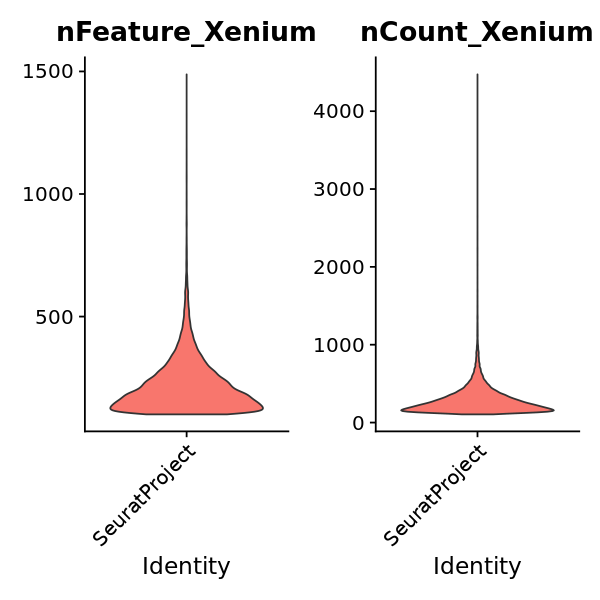

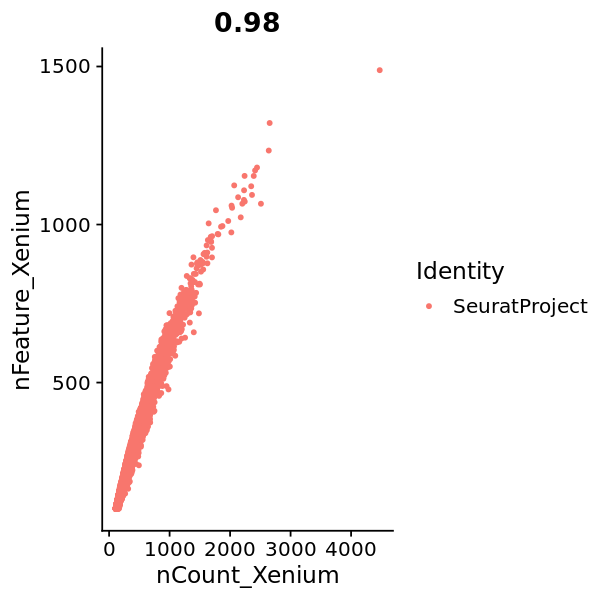

In [4]:
print("Summary of uniqueRNA")
print(summary(obj$nFeature_Xenium))
print("Summary of counts")
print(summary(obj$nCount_Xenium))

figsize(5,5)
Idents(obj) <- "SeuratProject"
VlnPlot(obj, features = c("nFeature_Xenium", "nCount_Xenium"), ncol = 2, pt.size = 0)
FeatureScatter(obj, feature1 = "nCount_Xenium", feature2 = "nFeature_Xenium") 

In [5]:
# Clean everything in case we did the PCA analysis before
obj <- DietSeurat(obj, dimreducs = "spatial")

# Normalize data and calculate cell cycle scores
obj <- NormalizeData(obj, normalization.method = "LogNormalize", scale.factor = 10000)
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
obj <- CellCycleScoring(obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: GINS2, CDCA7, DTL, PRIM1, MLF1IP, RFC2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, ATAD2, CDC45, TIPIN, DSCC1, USP1, CLSPN, POLA1, CHAF1B, E2F8, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NDC80, NUF2, CKS1B, TACC3, FAM64A, CKAP2L, TUBB4B, GTSE1, KIF20B, HJURP, HN1, NCAPD2, DLGAP5, CDCA8, ECT2, KIF23, ANLN, LBR, CENPE, G2E3, GAS2L3, not searching for symbol synonyms”


In [6]:
# Perform cluster analysis
obj <- FindVariableFeatures(obj, nfeatures = 2000) %>%
        ScaleData(do.scale=TRUE, vars.to.regress = c("S.Score", "G2M.Score")) %>%
        RunPCA(npcs=30) %>%
        RunUMAP(dims = 1:30, min.dist=0.05) %>%
        FindNeighbors(reduction = "pca", dims = 1:30) %>%
        FindClusters(resolution = c(0.1, 0.2, 0.3, 0.5, 0.8))

Regressing out S.Score, G2M.Score

Centering and scaling data matrix

PC_ 1 
Positive:  CLDN5, FAM107A, ENG, SHANK3, LRRC32, KLF4, SOCS3, ADAMTS1, VIPR1, CDKN1A 
	   TMEM100, THBD, EMP1, IL6, GIMAP5, CX3CL1, SLC6A4, SELP, CCL14, FENDRR 
	   PLVAP, NRN1, SOX17, STC2, SOX18, MCAM, SERPINE1, DLL4, CTNNAL1, ADAMTS4 
Negative:  DHCR24, NKX2-1, SDC4, CD55, EPCAM, ERRFI1, CDH1, CLDN18, TMPRSS2, MUC1 
	   SCNN1A, LAMB3, ALCAM, DDR1, SLC39A8, MALL, PTPRF, LPCAT1, ERBB3, ITGB6 
	   ABCA3, TSPAN13, CELSR1, ALPL, FOLR1, VEGFA, LAMP3, EHF, TACC2, NDNF 
PC_ 2 
Positive:  AGER, CLDN18, EMP2, RTKN2, NDNF, SLC39A8, ICAM1, ANXA3, TSPAN13, VEGFA 
	   AQP4, NKX2-1, CD55, LAMA3, ITGA3, DHCR24, LAMB3, COL4A3, HOPX, ADRB2 
	   PEBP4, LDLR, ERRFI1, PRKCZ, CLIC3, SOCS3, FOLR1, GPRIN2, COL4A4, ABCA1 
Negative:  PLVAP, ALOX15, IGFBP2, CCL14, PROM1, MUC5B, TEKT1, CFAP43, FOXJ1, SPAG6 
	   DNAH9, POSTN, ZMYND10, SPATA18, CP, SELP, MUC4, SLC22A4, CCDC113, CFB 
	   THY1, ENTPD1, CLDN1, SOX2, DRC1, STAB1, DNAI1, DLEC

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 42208
Number of edges: 1392072

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9548
Number of communities: 7
Elapsed time: 9 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 42208
Number of edges: 1392072

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9388
Number of communities: 12
Elapsed time: 9 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 42208
Number of edges: 1392072

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9273
Number of communities: 13
Elapsed time: 9 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 42208
Number of edges: 1392072

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9091
Number of communities: 15
Elapsed time: 8 seconds
Modularit

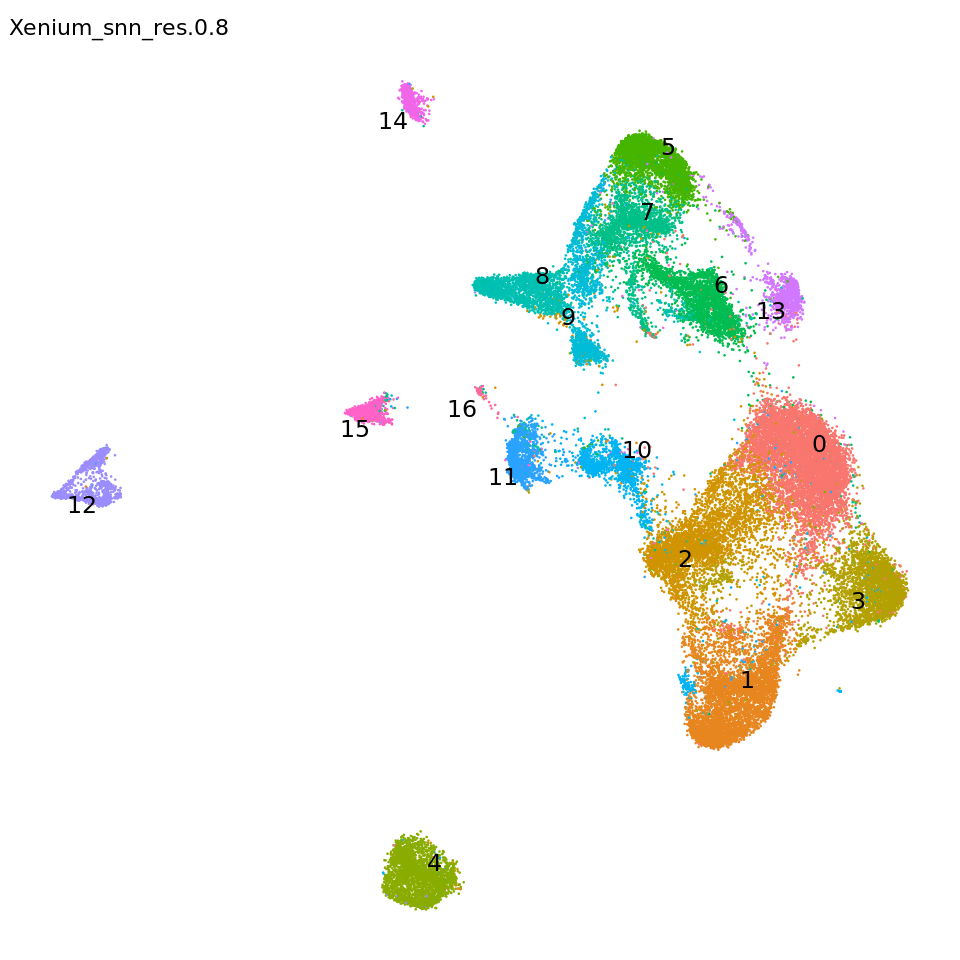

In [7]:
figsize(8, 8)
DimPlot(obj, group.by = "Xenium_snn_res.0.8", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void() + NoLegend()

Since alveolar cells were not included in reference data, they were predicted as endothelial cells by RCTD (non cancerous). Thus, we checked the alveolar cell marker gene expressions and reassigned a few clusters as alveolar cells. Those cells annotated as alveolar cells were excluded in further integration process.

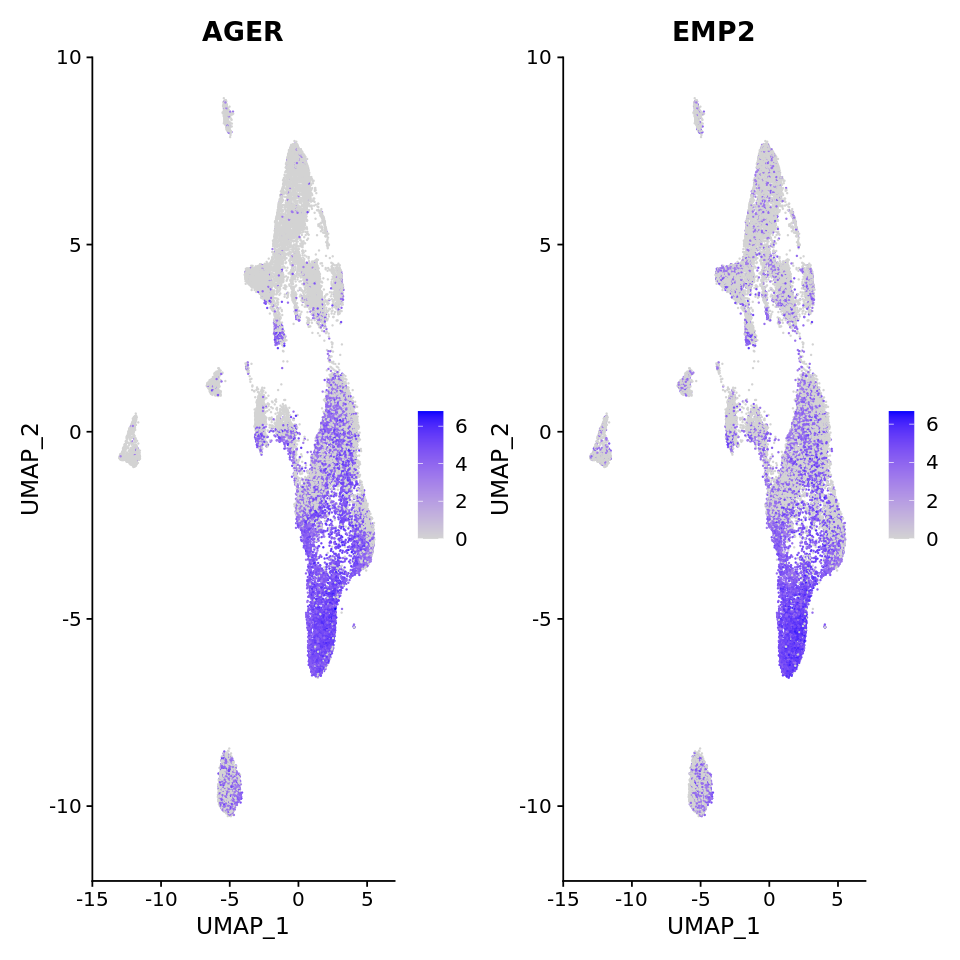

An object of class Seurat 
5001 features across 42208 samples within 1 assay 
Active assay: Xenium (5001 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
5001 features across 19465 samples within 1 assay 
Active assay: Xenium (5001 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

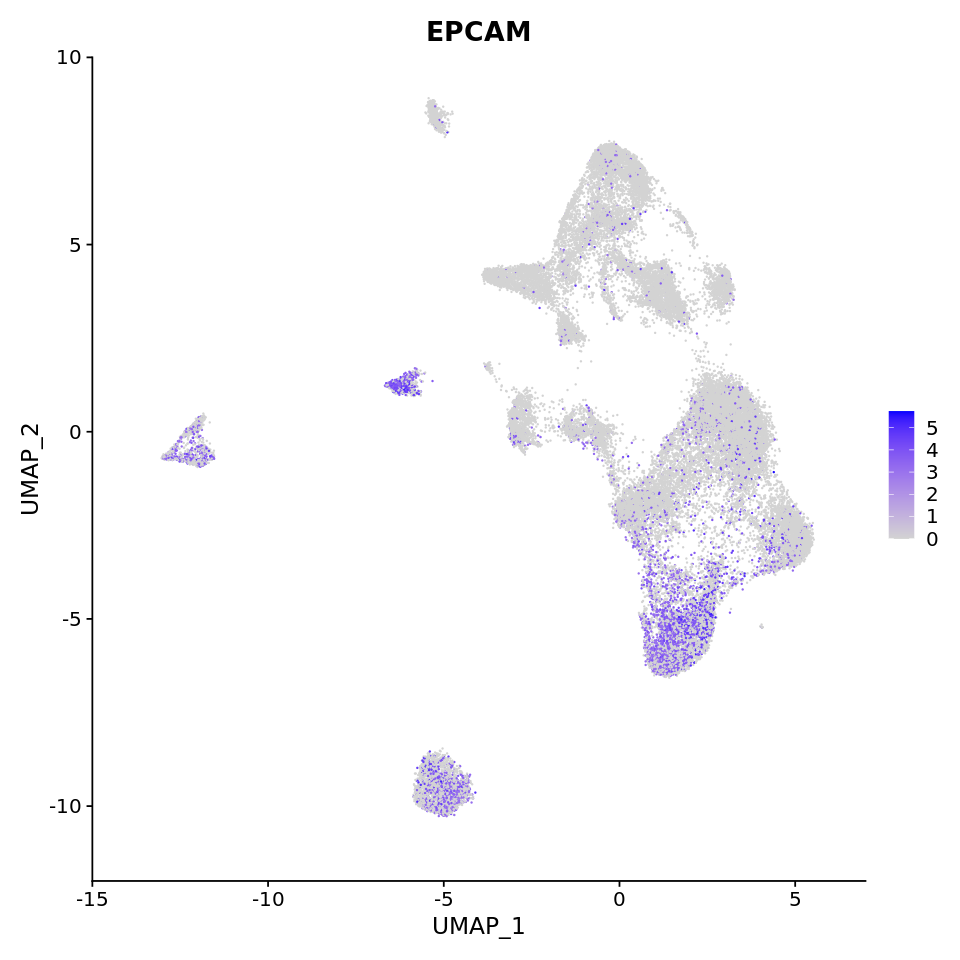

In [8]:
# Alveolar cell subtypes
FeaturePlot(obj, feature = c("AGER", "EMP2"))
FeaturePlot(obj, feature = "EPCAM")

# Annotate alveolar cells
obj$predicted.celltype <- as.character(obj$RCTD.predicted_celltype)
obj$predicted.celltype[obj$Xenium_snn_res.0.8 %in% c("0", "1", "2", "3", "4")] <- "Alveolar"
obj_alveolar <- obj
obj_alveolar

# Subset EC for further subtype annotation
obj <- subset(obj, subset = predicted.celltype != "Alveolar")
obj

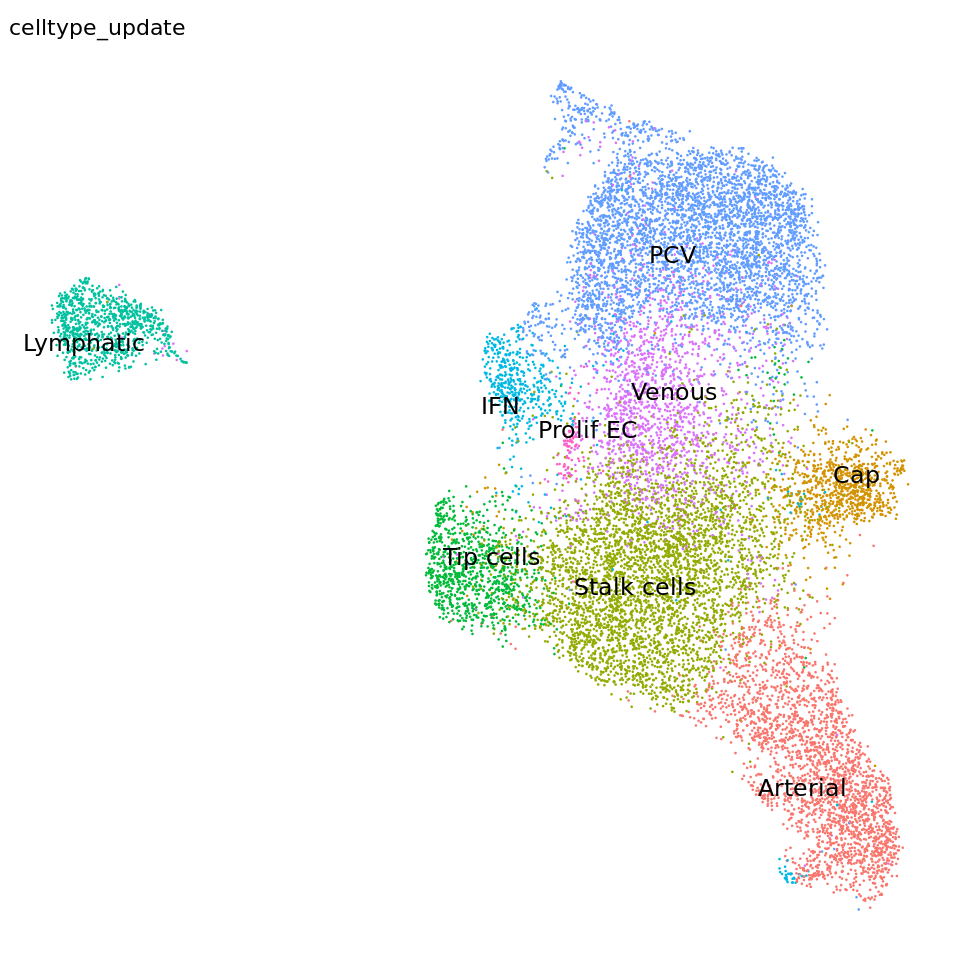

In [ ]:
# Subtype annotation in reference dataset (PanCancer atlas)
figsize(8, 8)
DimPlot(pancancer_sc, group.by = "celltype_update", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void()+ NoLegend()

## Seurat Integration
Credit: Sam

In [10]:
# Clean the spatial data
DefaultAssay(obj) <- "Xenium"
obj$Batch <- "Xenium"
pancancer_sc$Batch <- "Single-cell"

In [11]:
# Get the common genes between the two datasets
common_genes <- rownames(obj)[rownames(obj) %in% rownames(pancancer_sc)]
pancancer_sc <- pancancer_sc[common_genes, ]

In [12]:
# Create query subset
obj.query <- obj
obj.query <- obj.query[common_genes, ]

# Create reference dataset
obj.ref <- pancancer_sc
obj.ref <- RunPCA(obj.ref, npcs=30, verbose = F)
obj.ref$MM_type <- factor(obj.ref$celltype_update)

In [13]:
obj.ref
obj.query

An object of class Seurat 
5001 features across 15910 samples within 1 assay 
Active assay: RNA (5001 features, 632 variable features)
 4 dimensional reductions calculated: pca, harmony, umap, tsne

An object of class Seurat 
5001 features across 19465 samples within 1 assay 
Active assay: Xenium (5001 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [14]:
options(future.globals.maxSize= 6000*1024^2)

obj.query <- NormalizeData(obj.query)
obj.anchors <- FindTransferAnchors(reference = obj.ref,
                                        query = obj.query,
                                        dims = 1:30,
                                        reference.reduction = "pca")

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 17285 anchors

Filtering anchors

	Retained 4188 anchors



In [15]:
predictions <- TransferData(anchorset = obj.anchors, refdata = obj.ref$celltype_update, dims = 1:30)
obj.query <- AddMetaData(obj.query, metadata = predictions)

Finding integration vectors



Finding integration vector weights

Predicting cell labels



In [16]:
options(scipen = 999)
round(100*prop.table(table(obj.query$predicted.id)), 2)
round(100*prop.table(table(obj.ref$celltype_update)), 2)


   Arterial         Cap         IFN   Lymphatic         PCV   Prolif EC 
      21.89        4.22       10.09        7.64       38.09        0.58 
Stalk cells   Tip cells      Venous 
      11.51        3.18        2.79 


   Arterial         Cap Stalk cells   Tip cells   Lymphatic         IFN 
      15.53        5.71       25.52        6.04        5.81        3.22 
        PCV      Venous   Prolif EC 
      27.52       10.10        0.55 

In [17]:
obj.ref <- RunUMAP(obj.ref, dims = 1:30, reduction = "pca", return.model = TRUE)
obj.query <- MapQuery(anchorset = obj.anchors, reference = obj.ref, query = obj.query,
    refdata = list(celltype = "celltype_update"), reference.reduction = "pca", reduction.model = "umap")

UMAP will return its model

17:16:35 UMAP embedding parameters a = 0.9922 b = 1.112

17:16:35 Read 15910 rows and found 30 numeric columns

17:16:35 Using Annoy for neighbor search, n_neighbors = 30

17:16:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*


*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:16:37 Writing NN index file to temp file /tmp/Rtmp8r07az/file2c7b39425607ea

17:16:37 Searching Annoy index using 1 thread, search_k = 3000

17:16:44 Annoy recall = 99.99%

17:16:44 Commencing smooth kNN distance calibration using 1 thread

17:16:45 Initializing from normalized Laplacian + noise

17:16:45 Commencing optimization for 200 epochs, with 706576 positive edges

17:16:56 Optimization finished

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“All keys should be on

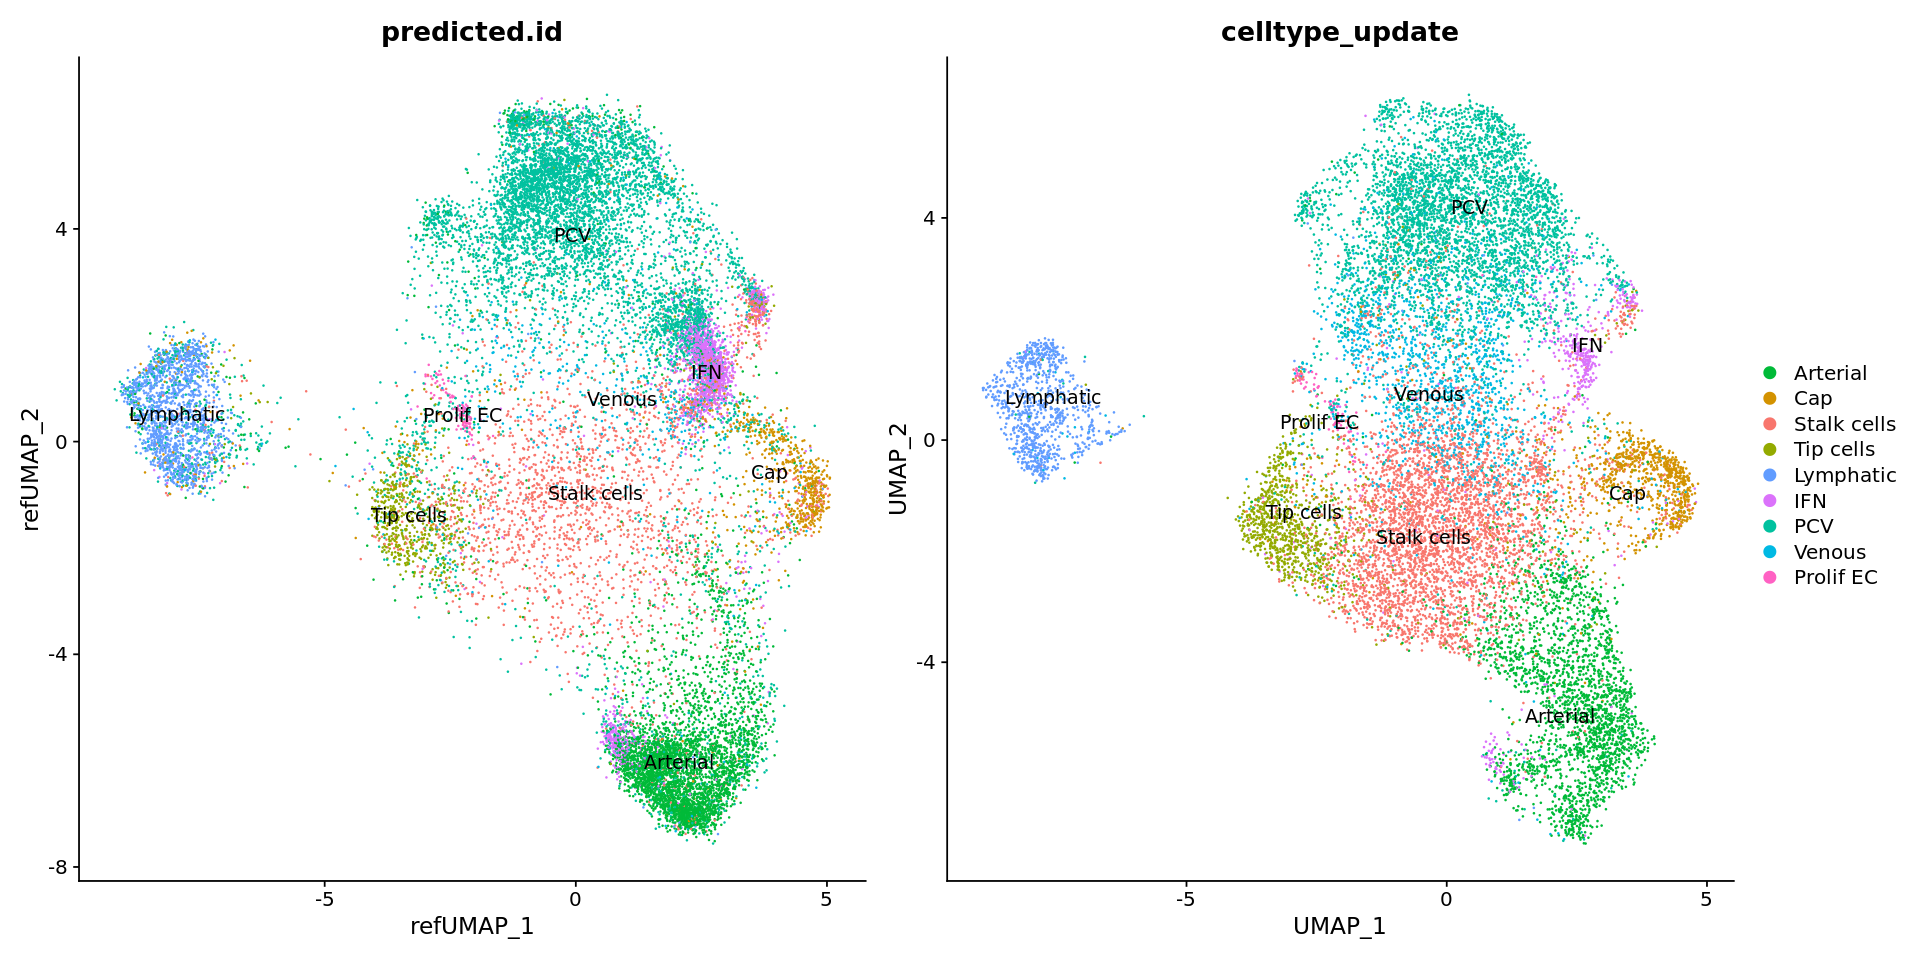

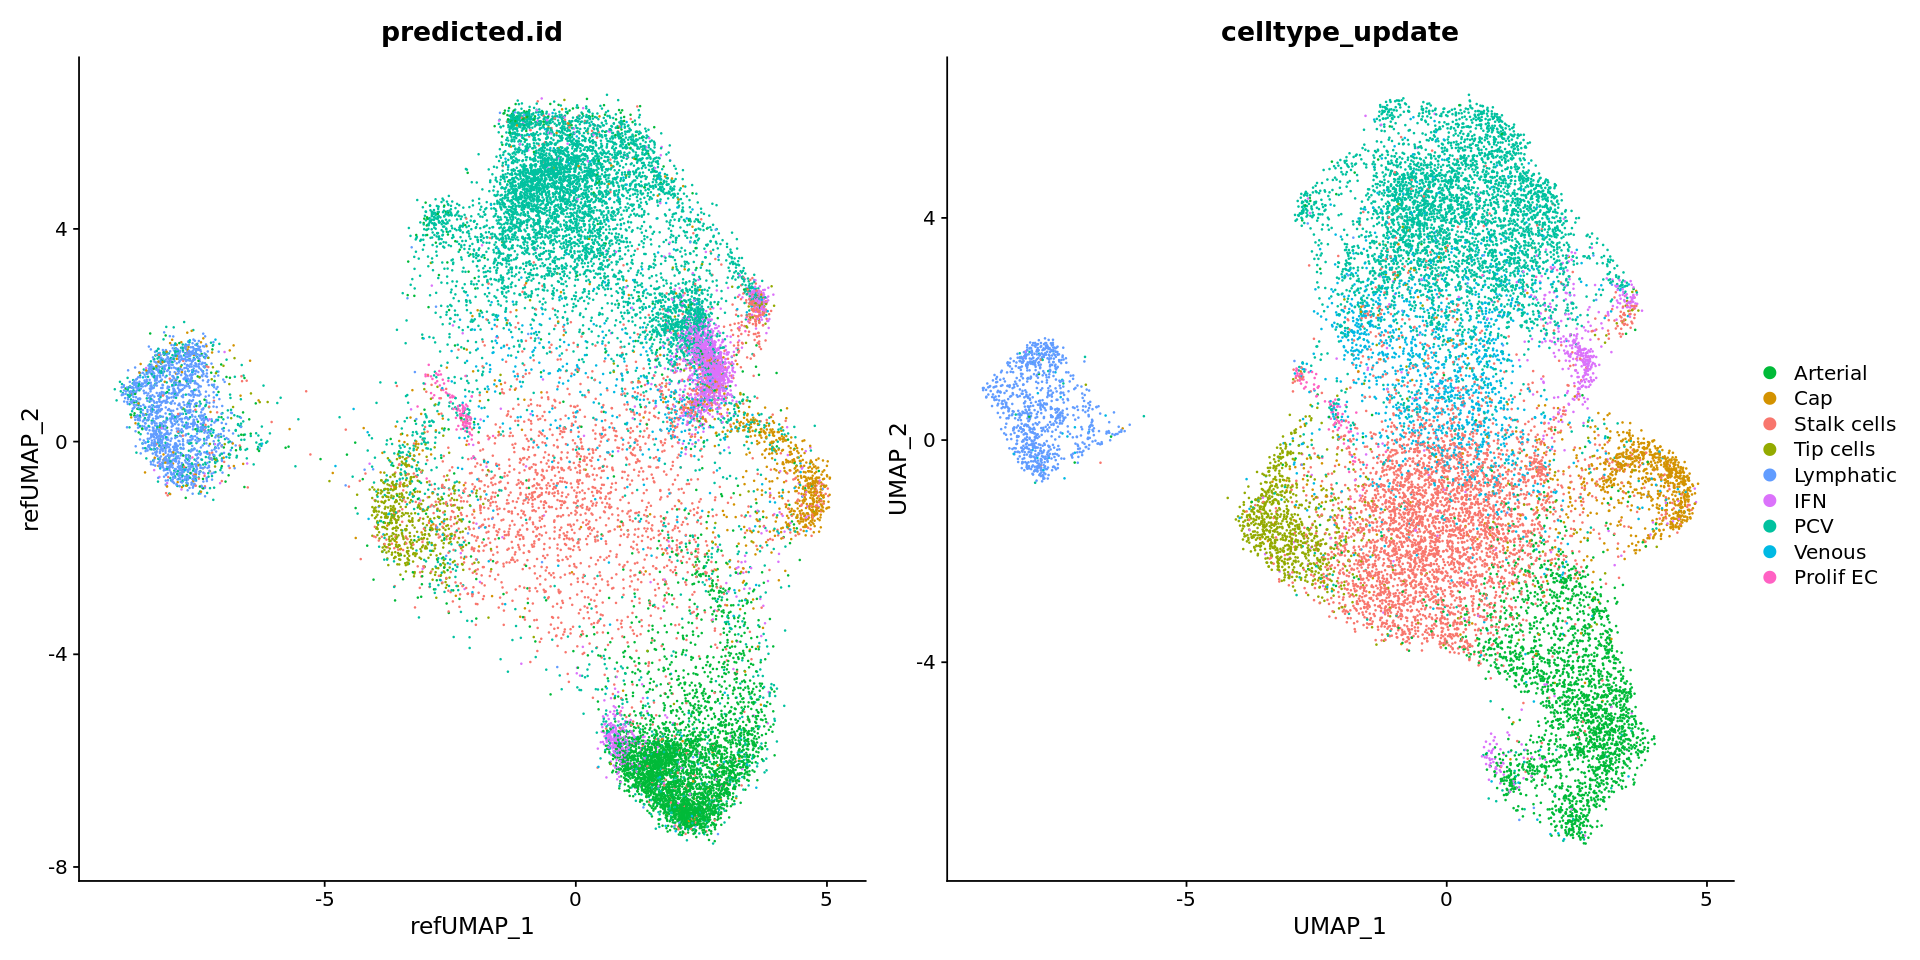

In [18]:
dd.col <- hue_pal()(length(unique(pancancer_sc$celltype_update)))
names(dd.col) <- unique(pancancer_sc$celltype_update)

figsize(16, 8)
(DimPlot(obj.query, reduction = "ref.umap", group.by="predicted.id", label=TRUE) + NoLegend()) + 
    DimPlot(obj.ref, reduction = "umap", group.by="celltype_update", label=TRUE, repel = TRUE) & 
    scale_color_manual(values = dd.col) 

(DimPlot(obj.query, reduction = "ref.umap", group.by="predicted.id") + NoLegend()) + 
    DimPlot(obj.ref, reduction = "umap", group.by="celltype_update") & 
    scale_color_manual(values = dd.col)

In [ ]:
obj_alveolar$predicted.celltype[obj_alveolar$predicted.celltype != "Alveolar"] <- as.character(obj.query$predicted.celltype)
saveRDS(obj_alveolar, file.path(dir, "EC_query.rds"))
saveRDS(obj.ref, file.path(dir, "EC_ref.rds"))

## Validate annotation - heatmap

In [22]:
obj.query <- readRDS(file.path(dir, "EC_query.rds"))
obj.ref <- readRDS(file.path(dir, "EC_ref.rds"))

In [25]:
Idents(obj) <- obj$`Xenium_snn_res.0.8`
markers <- FindAllMarkers(obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.5)
write.csv(markers, file = paste0(dir, "/FindAllMarkers_EC.csv"), row.names = FALSE)

Calculating cluster 0



Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16



In [19]:
source("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/Figure_functions.R")

EC_gene_list <- list(`Arterial` = c("MGP", "FBLN5", "GJA4", "GJA5", "SEMA3G", "LTBP4"),
                    `Capillary` = c("FABP4", "CD36", "CA4", "RBP7", "CD300LG", "BTNL9"),
                    `Stalk` = c("INSR", "COL4A1", "FLT1", "COL4A2", "EDNRB", "KDR"),
                    `Tip` = c("PGF", "TP53I11", "ESM1", "ADM", "APLN", "CHST1"),
                    `Lymphatic` = c("CCL21", "MMRN1", "PDPN", "LYVE1", "PROX1"),
                    `IFN EC` = c("CCL2", "CXCL9", "CXCL10", "UBD", "GBP2", "GBP5", "ISG15"),
                    `Venous` = c("ACKR1", "SELP", "SELE", "FBLN2", "VCAN", "NR2F2", "SLC02A1", "CSRP2", "VWF"),
                    `Proliferation` = c("MKI67", "TOP2A"),
                    `Alveolar`= c("AGER", "EMP2"))

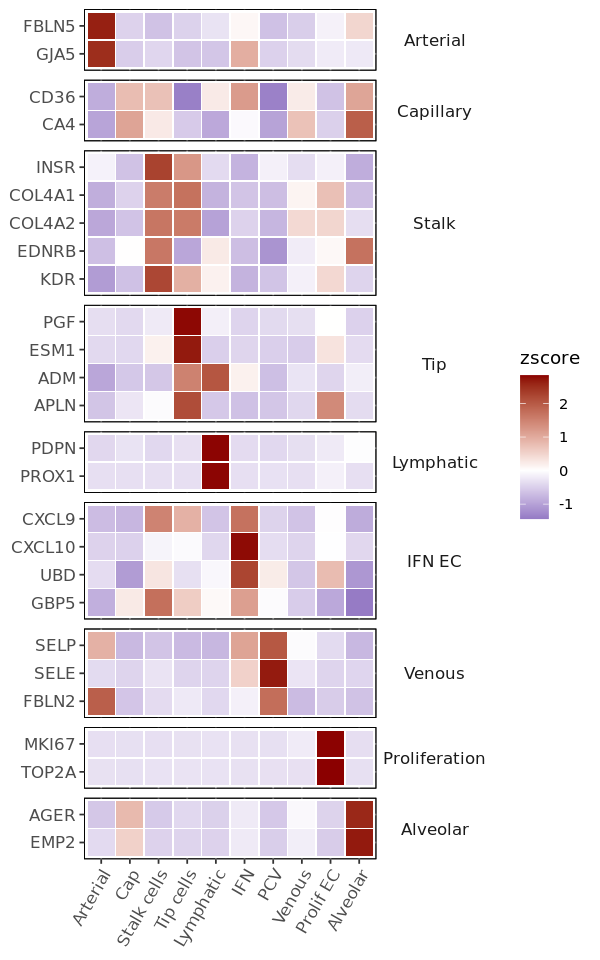

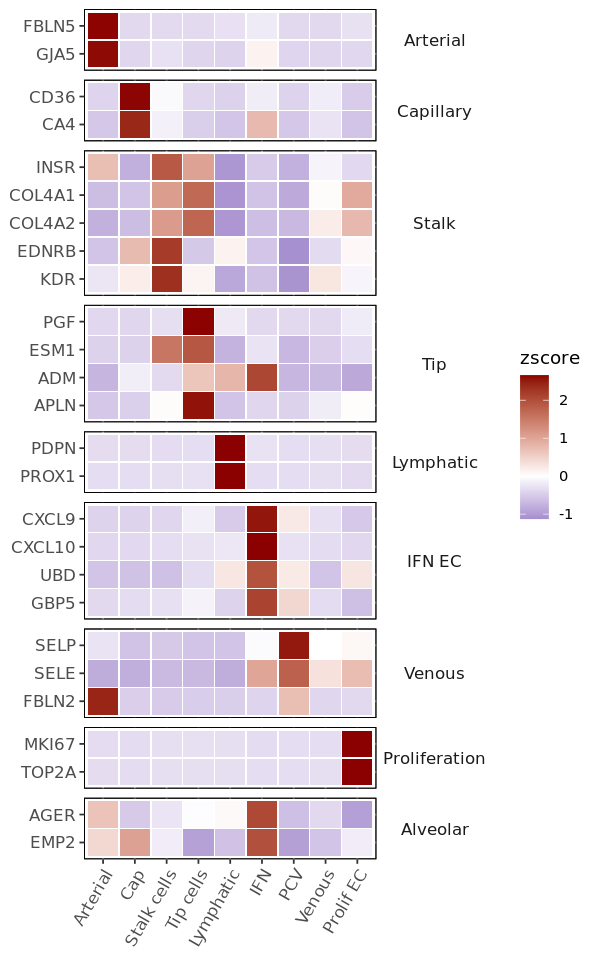

In [23]:
# figsize(8, 11)
# obj.query$cluster_rename <- paste0("cluster_", obj.query$`Xenium_snn_res.0.8`)
# heatmap(obj.query, genes = EC_gene_list, assay = "Xenium", group.by = "cluster_rename")
figsize(5, 8)
obj.query$predicted.celltype <- factor(obj.query$predicted.celltype, levels = c(as.character(levels(pancancer_sc$celltype_update)), "Alveolar"))
heatmap(obj.query, genes = EC_gene_list, assay = "Xenium", group.by = "predicted.celltype")
heatmap(pancancer_sc, genes = EC_gene_list, assay = "RNA", group.by = "celltype_update")